# Autoxidation reactions at daytime and nightime OH concentrations

This notebook examines the effect of including autoxidation reactions in the mechanism for aerosol oxidation by OH radicals at atmospheric conditions. Several properties are plotted as a function of diffusion coefficient and oxidant concentration. The diffusion coefficient is increased by an order of magnitude for each model scenario. The number after D indicates the negative base 10 logarithm of the diffusion coefficient for that scenario. The oxidant concentration is indicated by the condition where  day corresponds to daytime conditions ($5 \times 10^{6}$ molecules cm$^{-3}$) and night corresponds to nighttime conditions ($10^{5}$ molecules cm$^{-3}$). The data is first loaded in and processed, and then panel plots of each condition are produced. See Postprocesing.ipynb for a more detailed explanation of the data processing.

In [1]:
%%HTML 
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>

In [1]:
# Import modules

import warnings
warnings.filterwarnings('ignore')
import os
import zipfile

import StackSim
import numpy as np
import pandas as pd
from matplotlib import ticker
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import re
import natsort
from cycler import cycler

# Color gradient for plots
start = 0.85
stop = 0.0
num_lines = 5
cm_subsection = np.linspace(start, stop, num_lines)


colors = [ cm.magma(x) for x in cm_subsection ]

In [2]:
subdir = os.path.join(os.path.curdir, "auto_summary")

diffusion = ["SC", "D15", "D16", "D17", "D18"]
condition = ["day", "night", "diurnal"]
mechanism = ["", "_ao"]

D_string_conv = {"SC" : 1E-13, "D14" : 1E-14, "D15" : 1E-15, "D16" : 1E-16,
                "D17" : 1E-17, "D18" : 8.39E-19}

D_string_format = {"SC" : r"$>10^{-14}$", "D14" : r"$10^{-14}$",
                   "D15" : r"$10^{-15}$",
                   "D16" : r"$10^{-16}$", "D17" : r"$10^{-17}$", 
                   "D18" : r"$8.4 \times 10^{-19}$"}

auto_convert = {"" : " standard", "_ao" : " autoxidation"}

# Generate dictionary of filename strings

files = dict()

for cond in condition:
    for coefficient in diffusion:
        for mech in mechanism:
            
            filename = cond+"_"+coefficient+mech
            
            files[filename] = filename+".xlsx"
            
files["night_D14_ao"] = "night_D14_ao.xlsx"

## Simulation data plots

After processing the data, plots showing several different variables at different oxidant and diffusion coefficients are generated.

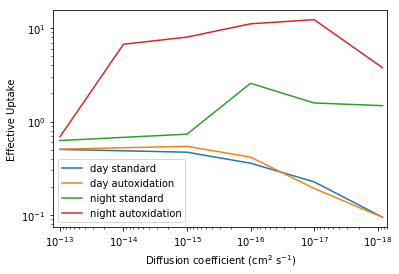

In [4]:
%matplotlib inline

diff_string = r'Diffusion coefficient (cm$^{2}$ s$^{-1}$)'
uptake_string = 'Effective Uptake'

condition_uptake = ["day", "night"]

uptake_data = dict()

fig, ax = plt.subplots(1)

for cond in condition_uptake:

    
    # Get uptake coefficient from each file
    for mech in mechanism:
        coef = np.array([])
        uptake = np.array([])
        for D in diffusion:

            with pd.ExcelFile(os.path.join(subdir, files[cond+"_"+D+mech])) as xlsx:
                df = pd.read_excel(xlsx, 'model summary')
            coef = np.append(coef, D_string_conv[D])
            uptake = np.append(uptake, df[uptake_string].iloc[0])
            
        # Include extra data for autoxidation simulation at night for D = 10^-14 cm^2 s^-1
        if(cond == "night" and mech == "_ao"):
            
            with pd.ExcelFile(os.path.join(subdir, files["night_D14_ao"]))as xlsx:
                df = pd.read_excel(xlsx, 'model summary')
            coef = np.append(coef, D_string_conv["D14"])
            uptake = np.append(uptake, df[uptake_string].iloc[0])
            
        # Put in data frame
        uptake_data[cond+mech] = pd.DataFrame({diff_string : coef, 
                                      cond+auto_convert[mech] : uptake})
        
        # Sort uptake data
        uptake_data[cond+mech].sort_values(diff_string, inplace=True)
        
        # Plot data
        uptake_data[cond+mech].plot(x = diff_string, y = cond+auto_convert[mech],
                          ax = ax, logx=True, logy=True, xlim=(1.3E-10, 7E-19))

ax.set_xlim([1.3E-13, 7E-19])
#ax.set_ylim([0, 0.52])
ax.set_xlabel(diff_string)
ax.set_ylabel(uptake_string)


fig.savefig(os.path.join(subdir, 'effuptake.png'),
            fmt='png', dpi=300, bbox_inches='tight')

In [3]:
# Load data to be graphed below.

ScenarioData = dict()
OC_contours = dict()
Tri_contours = dict()
Peroxy_contours = dict()
RO2_bimol_contours = dict()
RO2_auto_contours = dict()
ROprop_contours = dict()

for file in files.keys():
        
    with pd.ExcelFile(os.path.join(subdir, files[file])) as xlsx:
        
        ScenarioData[file] = pd.read_excel(xlsx, 'average data', header=0)
        ScenarioData[file]['Time (hours)'] = ScenarioData[file]['Time (s)']/3600
            
        Tri_contours[file] = pd.read_excel(xlsx, 'Triacontane (normalized)',
                                         skiprows=0, index_col=0, header=1)
        OC_contours[file] = pd.read_excel(xlsx, 'O to C ratio',
                                        skipows=0, index_col=0, header=1)
        if not "SC" in file:
            RO2_bimol_contours[file] = pd.read_excel(xlsx, 'RO2+RO2',
                                        skipows=0, index_col=0, header=1)
            if "ao" in file:

                RO2_auto_contours[file] = pd.read_excel(xlsx, 'RO2prop_ch2',
                                        skipows=0, index_col=0, header=1)
                ROprop_contours[file] = pd.read_excel(xlsx, 'ROprop',
                                        skipows=0, index_col=0, header=1)



In [14]:
# Function for plotting condensed simulation data

def plot_property(data_string):
    fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(9, 6))
    
    fig.suptitle(data_string, size = 12)

    plt.subplots_adjust(wspace=0.1, hspace = 0.1)

    cycle = cycler('color', colors) + \
                cycler('linestyle', ['-', '--', '-.', ':', '-'])

    i = 0
    for mech in mechanism:
        j = 0
        for cond in condition:
            axes[i, j].set_prop_cycle(cycle)
            for D in diffusion:
                ScenarioData[cond+"_"+D+mech].plot(x = 'Time (hours)', y = data_string,
                                                  ax = axes[i, j], legend = False)
                if i == 0:
                    axes[i, j].set_title(cond)
                if j == 0:
                    axes[i, j].set_ylabel(auto_convert[mech])


            j += 1

        i += 1

    labels = [D_string_format[entry] + r' cm$^{2}$ s$^{-1}$' for entry in diffusion]

    axes[0, 1].legend(labels, loc = 'best')
    
    data_string = re.sub("/", " to ", data_string)
    
    fig.savefig(os.path.join(subdir, data_string+'_condensed.png'),
                fmt='png', dpi=600, bbox_inches='tight')

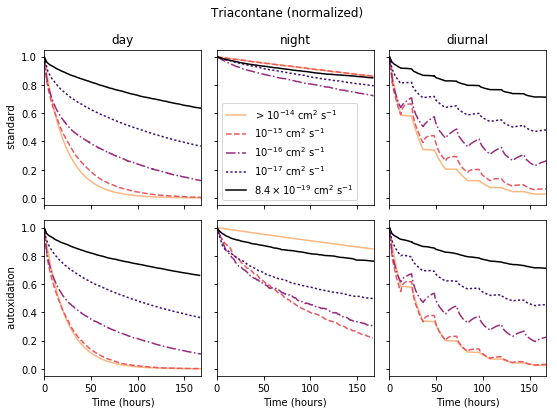

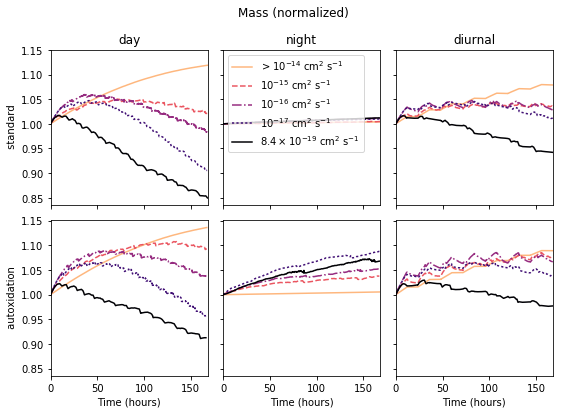

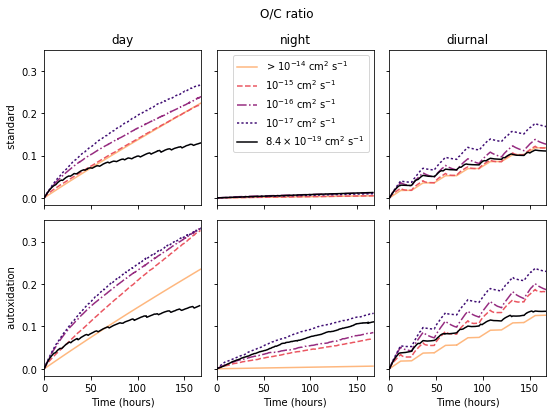

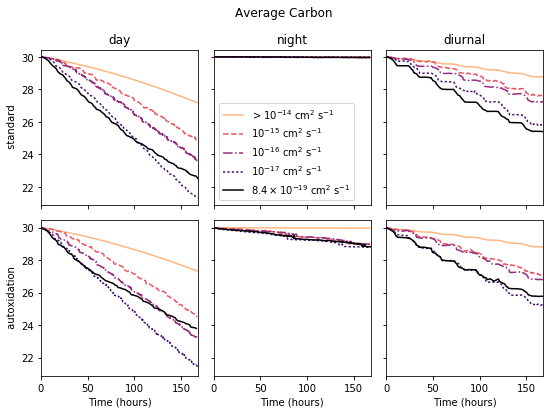

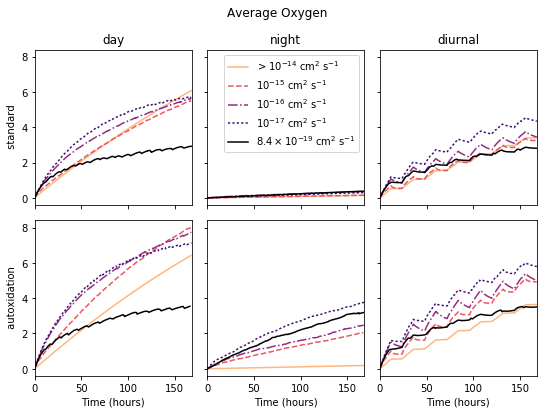

In [15]:
%matplotlib inline

data_list = ["Triacontane (normalized)", "Mass (normalized)", "O/C ratio", "Average Carbon", "Average Oxygen"]

for data in data_list:
    plot_property(data)

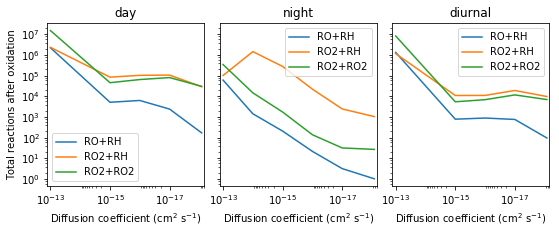

In [41]:
%matplotlib inline

diffusions = ["SC", "D15", "D16", "D17", "D18"]

# Plot for marker data

fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(9, 3))

plt.subplots_adjust(wspace=0.1, hspace=0.1)

prop_data = dict()

i = 0
for cond in condition:
    axes[i].set_title(cond)
    coef = np.array([])
    ro2_bimo = np.array([])
    ro2_auto = np.array([])
    ro_prop = np.array([])
    oh_prop = np.array([])
    
    if cond == "night":
            df = ScenarioData[cond+"_D14_ao"]
            coef = np.append(coef, D_string_conv["D14"])
            ro2_bimo = np.append(ro2_bimo, df["RO2+RO2"].iloc[-1])
            ro2_auto = np.append(ro2_auto, df["RO2prop_tot"].iloc[-1])
            ro_prop = np.append(ro_prop, df["ROprop"].iloc[-1])
            
            
    # Get total of each type of propagation reaction from files
    for D in diffusions:
            df = ScenarioData[cond+"_"+D+"_ao"]
            coef = np.append(coef, D_string_conv[D])
            ro2_bimo = np.append(ro2_bimo, df["RO2+RO2"].iloc[-1])
            ro2_auto = np.append(ro2_auto, df["RO2prop_tot"].iloc[-1])
            ro_prop = np.append(ro_prop, df["ROprop"].iloc[-1])
            

    
    # Put in data frame
    prop_data[cond] = pd.DataFrame({diff_string : coef, "RO2+RO2" : ro2_bimo, 
                                   "RO2+RH" : ro2_auto, "RO+RH" : ro_prop})
    
    # sort by diffusion coefficient
    prop_data[cond].sort_values(diff_string, inplace=True)
    
    prop_data[cond].plot(x = diff_string, ax=axes[i], xlim=(1.3E-13, 7E-19),
                        kind='line', legend=True, logx=True, logy=True)
    
    if i == 0:
        axes[i].set_ylabel("Total reactions after oxidation")
    
    
    
    i += 1
    
        
fig.savefig(os.path.join(subdir, 'reaction_markers.png'),
           fmt='png', dpi=600, bbox_inches='tight')


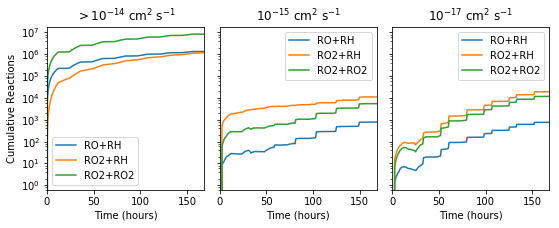

In [45]:
%matplotlib inline

diffusions = ["SC", "D15", "D17"]

# Plot time dependence of reactions for diurnal cycle

fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(9, 3))

plt.subplots_adjust(wspace=0.1, hspace=0.1)

i = 0
for D in diffusions:
    
    axes[i].set_title(D_string_format[D] + r' cm$^{2}$ s$^{-1}$')
    ScenarioData["diurnal_"+D+"_ao"].plot(x = 'Time (hours)', y = ["ROprop", "RO2prop_tot", "RO2+RO2"], 
                                         ax = axes[i], logy=True)
    
    axes[i].legend(["RO+RH", "RO2+RH", "RO2+RO2"])
    
    i += 1

axes[0].set_ylabel("Cumulative Reactions")

fig.savefig(os.path.join(subdir, 'diurnal_markers.png'),
           fmt='png', dpi=600, bbox_inches='tight')

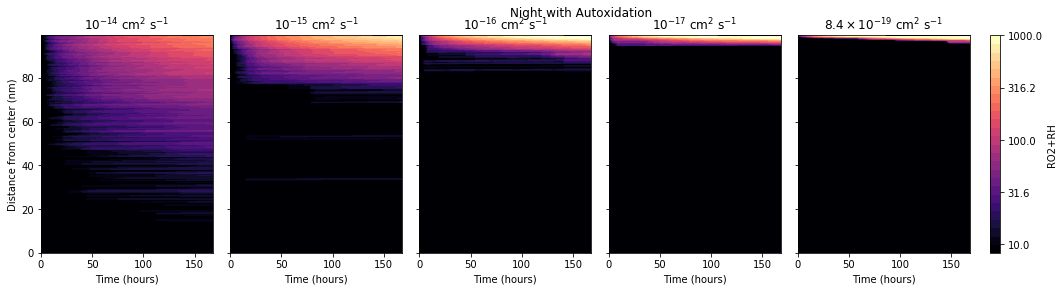

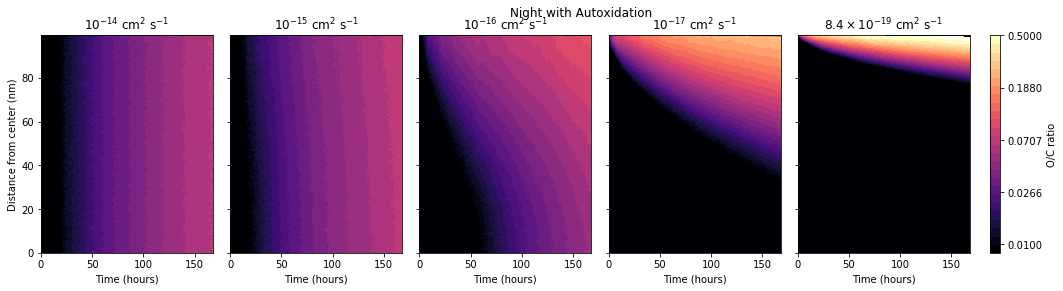

In [79]:
%matplotlib inline

def night_auto_contours(data_dict, label = "", subidx=0, limits = (0, 1)):
    
    # Set up color map labels and levels
    N_levels = 26
    N_labels = 5
    
    levels = np.array([0])
    levels = np.append(levels, np.logspace(limits[0], limits[1], num = N_levels, base = 10.0))
    
    labels = np.logspace(limits[0], limits[1], num = N_labels, base = 10)
    
    
    cmap = cm.get_cmap('magma', N_levels)
    
    norm = mpl.colors.BoundaryNorm(levels, cmap.N)

    # Contour maps showing different variables for the nighttime autoxidation data set

    fig, axes = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(20, 4))

    plt.subplots_adjust(wspace=0.1)
    
    fig.suptitle("Night with Autoxidation")

    i = 0
    for D in ["D14", "D15", "D16", "D17", "D18"]:
        
        
        axes[i].set_title(D_string_format[D] + r' cm$^{2}$ s$^{-1}$')
        data = data_dict["night_"+D+"_ao"]
        
        contf = axes[i].contourf(data.columns.values/3600, data.index[subidx:-1]/1E-7, data.iloc[subidx:-1, :],
                                cmap=cmap, levels = levels, norm = norm, spacing = 'uniform')

        #cb = fig.colorbar(contf, ax = axes[i], ticks = labels)
        #cb.set_label(label)
    
        axes[i].set_xlabel("Time (hours)")
    
        i += 1

    axes[0].set_ylabel("Distance from center (nm)")
    
    cb = fig.colorbar(contf, ax=axes.ravel().tolist(), ticks = labels)

    cb.set_label(label)
    
    fig.subplots_adjust(right=0.77)
    
    label = re.sub("/", " to ", label)
    
    fig.savefig(os.path.join(subdir, label+"_contour.png"),
           fmt='png', dpi=600, bbox_inches='tight')
    
    plt.show()

night_auto_contours(RO2_auto_contours, label = "RO2+RH", limits = (1, 3))
night_auto_contours(OC_contours, label = "O/C ratio", limits = (-2, -0.30102999566398114))

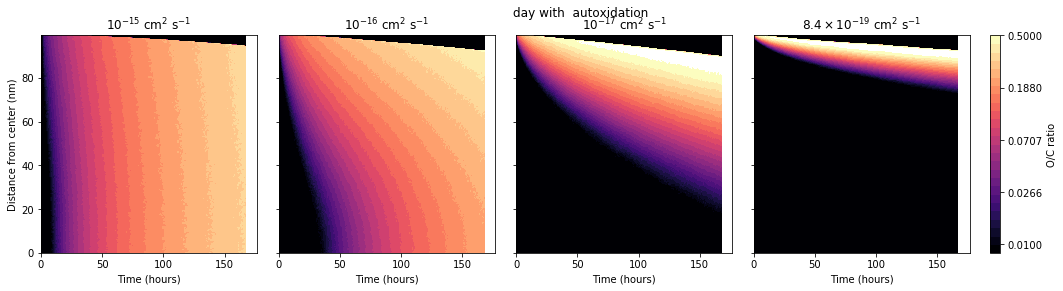

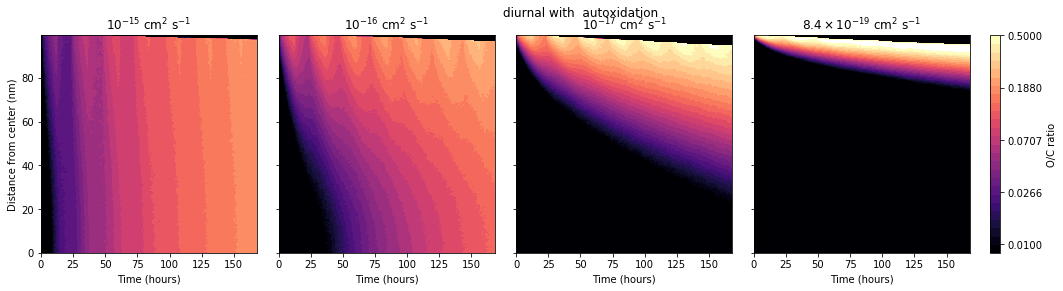

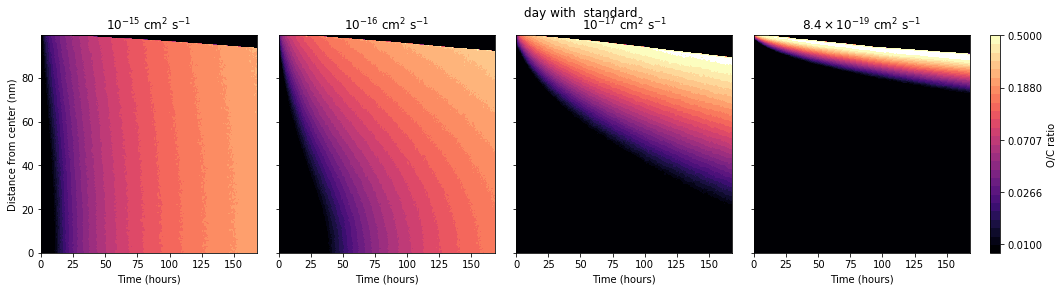

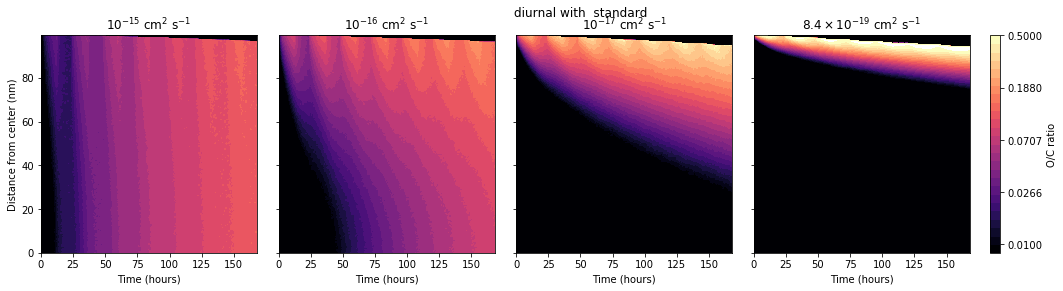

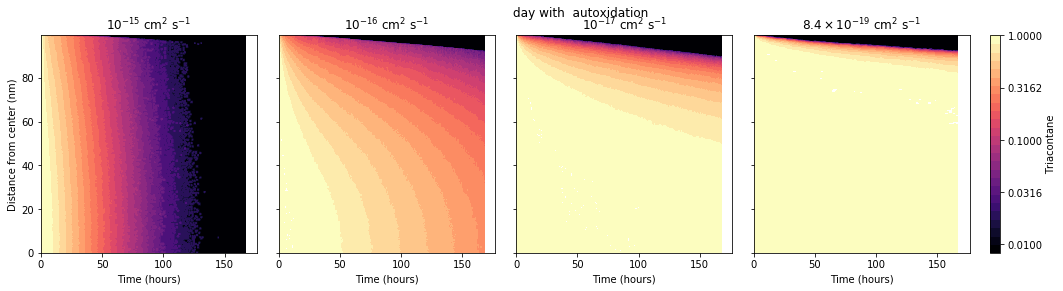

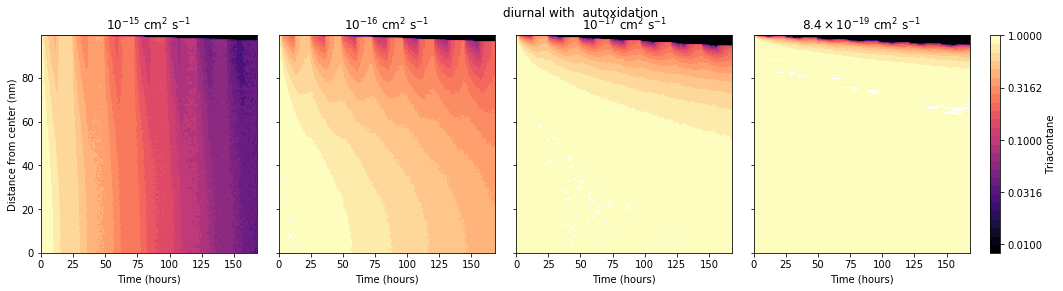

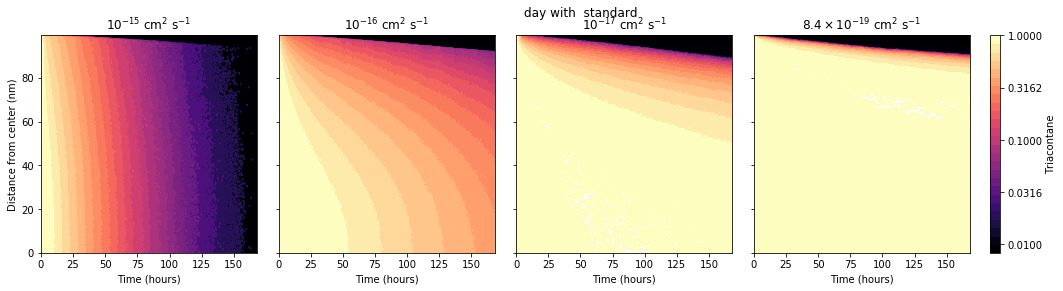

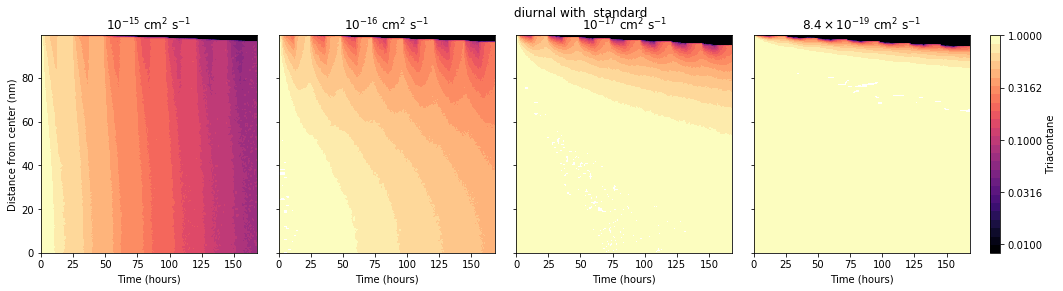

In [10]:
%matplotlib inline

def contour_comp(data_dict, cond, mech, label = "", subidx=0, limits = (0, 1)):
    
    # Set up color map labels and levels
    N_levels = 26
    N_labels = 5
    
    levels = np.array([0])
    levels = np.append(levels, np.logspace(limits[0], limits[1], num = N_levels, base = 10.0))
    
    labels = np.logspace(limits[0], limits[1], num = N_labels, base = 10)
    
    
    cmap = cm.get_cmap('magma', N_levels)
    
    norm = mpl.colors.BoundaryNorm(levels, cmap.N)

    # Contour maps showing different variables for the nighttime autoxidation data set

    fig, axes = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(20, 4))

    plt.subplots_adjust(wspace=0.1)
    
    fig.suptitle(cond+" with "+auto_convert[mech])

    i = 0
    for D in ["D15", "D16", "D17", "D18"]:
        
        
        axes[i].set_title(D_string_format[D] + r' cm$^{2}$ s$^{-1}$')
        data = data_dict[cond+"_"+D+mech]
        
        contf = axes[i].contourf(data.columns.values/3600, data.index[subidx:-1]/1E-7, data.iloc[subidx:-1, :],
                                cmap=cmap, levels = levels, norm = norm, spacing = 'uniform')

        #cb = fig.colorbar(contf, ax = axes[i], ticks = labels)
        #cb.set_label(label)
    
        axes[i].set_xlabel("Time (hours)")
    
        i += 1

    axes[0].set_ylabel("Distance from center (nm)")
    
    cb = fig.colorbar(contf, ax=axes.ravel().tolist(), ticks = labels)

    cb.set_label(label)
    
    fig.subplots_adjust(right=0.77)
    
    label = re.sub("/", " to ", label)
    
    fig.savefig(os.path.join(subdir, cond+mech+"_"+label+"_contour.png"),
           fmt='png', dpi=600, bbox_inches='tight')
    
    plt.show()


contour_comp(OC_contours, cond="day", mech="_ao", label = "O/C ratio", limits = (-2, -0.30102999566398114))
contour_comp(OC_contours, cond="diurnal", mech="_ao", label = "O/C ratio", limits = (-2, -0.30102999566398114))
contour_comp(OC_contours, cond="day", mech="", label = "O/C ratio", limits = (-2, -0.30102999566398114))
contour_comp(OC_contours, cond="diurnal", mech="", label = "O/C ratio", limits = (-2, -0.30102999566398114))
contour_comp(Tri_contours, cond="day", mech="_ao", label = "Triacontane", limits = (-2, 0))
contour_comp(Tri_contours, cond="diurnal", mech="_ao", label = "Triacontane", limits = (-2, 0))
contour_comp(Tri_contours, cond="day", mech="", label = "Triacontane", limits = (-2, 0))
contour_comp(Tri_contours, cond="diurnal", mech="", label = "Triacontane", limits = (-2, 0))

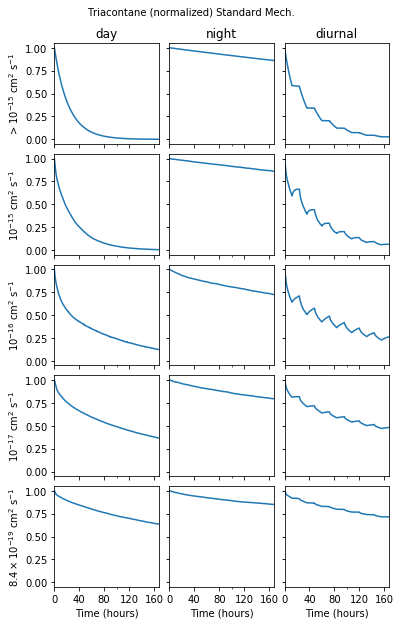

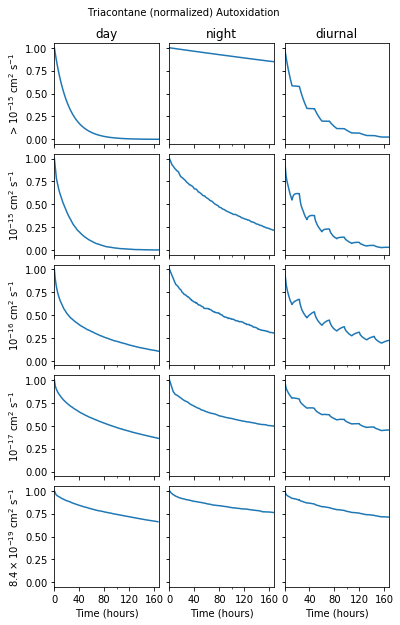

In [5]:
%matplotlib inline

# Plot for triacontane loss without autoxidation

fig, axes = plt.subplots(5, 3, sharex=True, sharey=True, figsize=(6, 10))

data_string = "Triacontane (normalized)"

plt.figtext(0.2, 0.92, data_string+" Standard Mech.")

plt.subplots_adjust(wspace=0.1, hspace=0.1)

i = 0
for cond in condition:
    j = 0
    for D in diffusion:
        ScenarioData[cond+"_"+D].plot(x = 'Time (hours)', y = data_string,
                                      ax = axes[j, i], legend=False)
        axes[j, i].xaxis.set_major_locator(ticker.MaxNLocator(5))
        if j == 0:
            axes[j, i].set_title(cond)
        if i == 0:
            axes[j, i].set_ylabel(D_string_format[D]+r" cm$^2$ s$^{-1}$")
        j += 1
    i += 1

fig.savefig(os.path.join(subdir, 'triacontane_vert_standard.png'),
            fmt='png', dpi=600, bbox_inches='tight')    

# Plot for triacontane loss without autoxidation

fig, axes = plt.subplots(5, 3, sharex=True, sharey=True, figsize=(6, 10))

plt.figtext(0.2, 0.92, data_string+" Autoxidation")

plt.subplots_adjust(wspace=0.1, hspace=0.1)

i = 0
for cond in condition:
    j = 0
    for D in diffusion:

            
        ScenarioData[cond+"_"+D+"_ao"].plot(x = 'Time (hours)', y = data_string,
                                      ax = axes[j, i], legend=False)
        axes[j, i].xaxis.set_major_locator(ticker.MaxNLocator(5))
        if j == 0:
            axes[j, i].set_title(cond)
        if i == 0:
            axes[j, i].set_ylabel(D_string_format[D]+r" cm$^2$ s$^{-1}$")
        j += 1
    i += 1

fig.savefig(os.path.join(subdir, 'triacontane_vert_autoxidation.png'),
            fmt='png', dpi=600, bbox_inches='tight')    



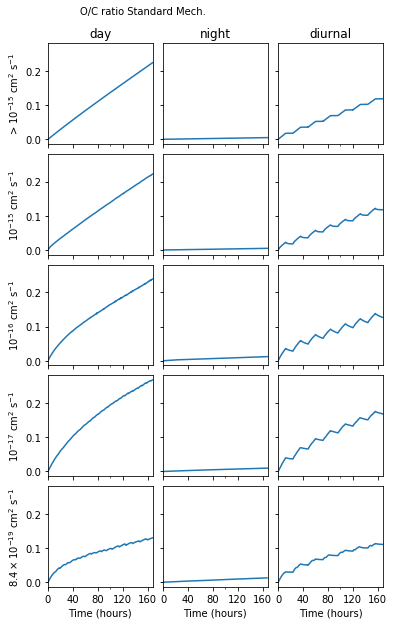

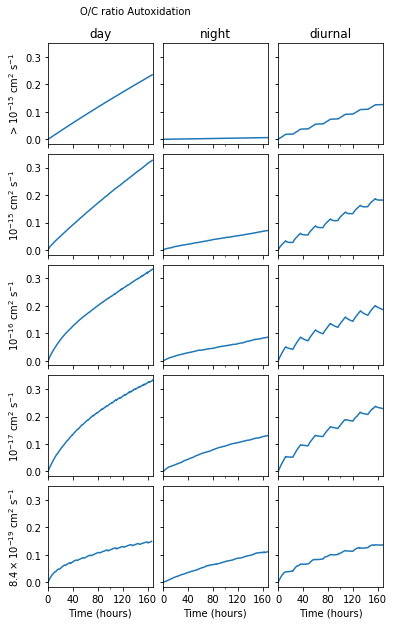

In [7]:
%matplotlib inline

# Plot for O/C ratio without autoxidation

fig, axes = plt.subplots(5, 3, sharex=True, sharey=True, figsize=(6, 10))

data_string = "O/C ratio"

plt.figtext(0.2, 0.92, data_string+" Standard Mech.")

plt.subplots_adjust(wspace=0.1, hspace=0.1)

i = 0
for cond in condition:
    j = 0
    for D in diffusion:
        ScenarioData[cond+"_"+D].plot(x = 'Time (hours)', y = data_string,
                                      ax = axes[j, i], legend=False)
        axes[j, i].xaxis.set_major_locator(ticker.MaxNLocator(5))
        if j == 0:
            axes[j, i].set_title(cond)
        if i == 0:
            axes[j, i].set_ylabel(D_string_format[D]+r" cm$^2$ s$^{-1}$")
        j += 1
    i += 1

fig.savefig(os.path.join(subdir, 'OCratio_vert_standard.png'),
            fmt='png', dpi=600, bbox_inches='tight')    

# Plot for O/C ratio without autoxidation

fig, axes = plt.subplots(5, 3, sharex=True, sharey=True, figsize=(6, 10))

plt.figtext(0.2, 0.92, data_string+" Autoxidation")

plt.subplots_adjust(wspace=0.1, hspace=0.1)

i = 0
for cond in condition:
    j = 0
    for D in diffusion:

            
        ScenarioData[cond+"_"+D+"_ao"].plot(x = 'Time (hours)', y = data_string,
                                      ax = axes[j, i], legend=False)
        axes[j, i].xaxis.set_major_locator(ticker.MaxNLocator(5))
        if j == 0:
            axes[j, i].set_title(cond)
        if i == 0:
            axes[j, i].set_ylabel(D_string_format[D]+r" cm$^2$ s$^{-1}$")
        j += 1
    i += 1

fig.savefig(os.path.join(subdir, 'OC_ratio_vert_autoxidation.png'),
            fmt='png', dpi=600, bbox_inches='tight')    


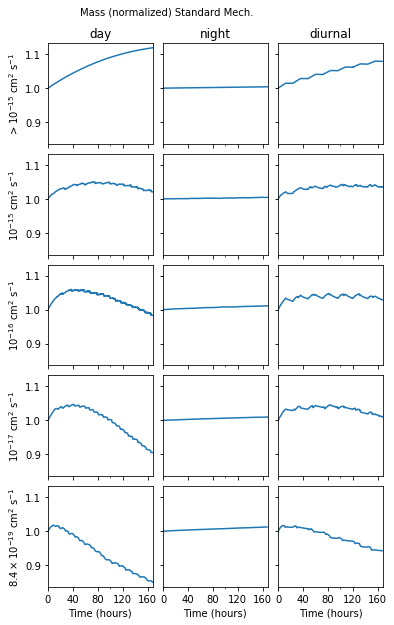

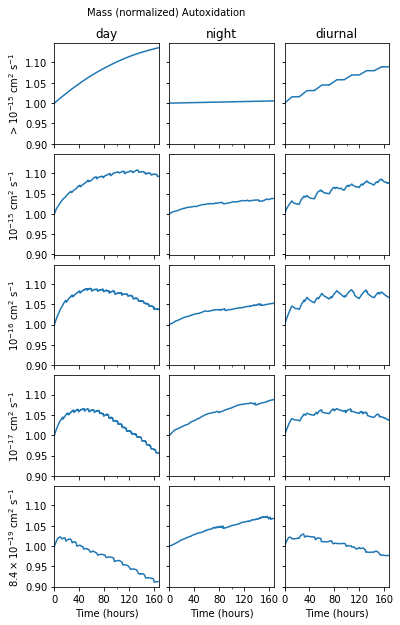

In [8]:
%matplotlib inline

# Plot for mass without autoxidation

fig, axes = plt.subplots(5, 3, sharex=True, sharey=True, figsize=(6, 10))

data_string = "Mass (normalized)"

plt.figtext(0.2, 0.92, data_string+" Standard Mech.")

plt.subplots_adjust(wspace=0.1, hspace=0.1)

i = 0
for cond in condition:
    j = 0
    for D in diffusion:
        ScenarioData[cond+"_"+D].plot(x = 'Time (hours)', y = data_string,
                                      ax = axes[j, i], legend=False)
        axes[j, i].xaxis.set_major_locator(ticker.MaxNLocator(5))
        if j == 0:
            axes[j, i].set_title(cond)
        if i == 0:
            axes[j, i].set_ylabel(D_string_format[D]+r" cm$^2$ s$^{-1}$")
        j += 1
    i += 1

fig.savefig(os.path.join(subdir, 'mass_vert_standard.png'),
            fmt='png', dpi=600, bbox_inches='tight')    

# Plot for mass without autoxidation

fig, axes = plt.subplots(5, 3, sharex=True, sharey=True, figsize=(6, 10))

plt.figtext(0.2, 0.92, data_string+" Autoxidation")

plt.subplots_adjust(wspace=0.1, hspace=0.1)

i = 0
for cond in condition:
    j = 0
    for D in diffusion:

            
        ScenarioData[cond+"_"+D+"_ao"].plot(x = 'Time (hours)', y = data_string,
                                      ax = axes[j, i], legend=False)
        axes[j, i].xaxis.set_major_locator(ticker.MaxNLocator(5))
        if j == 0:
            axes[j, i].set_title(cond)
        if i == 0:
            axes[j, i].set_ylabel(D_string_format[D]+r" cm$^2$ s$^{-1}$")
        j += 1
    i += 1

fig.savefig(os.path.join(subdir, 'mass_vert_autoxidation.png'),
            fmt='png', dpi=600, bbox_inches='tight')

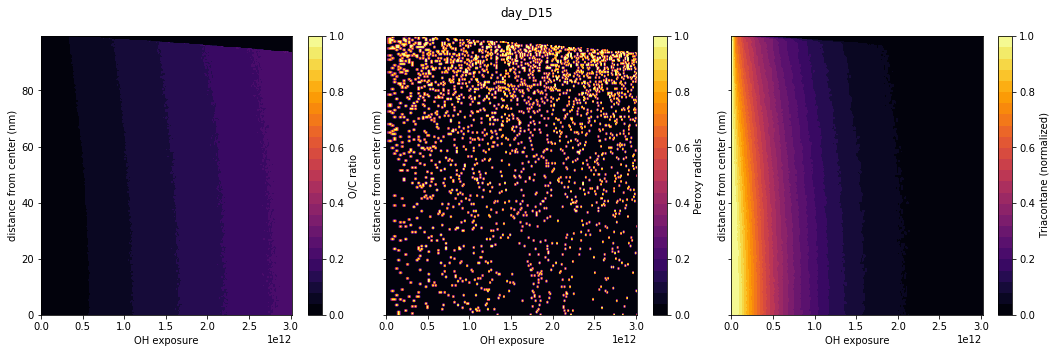

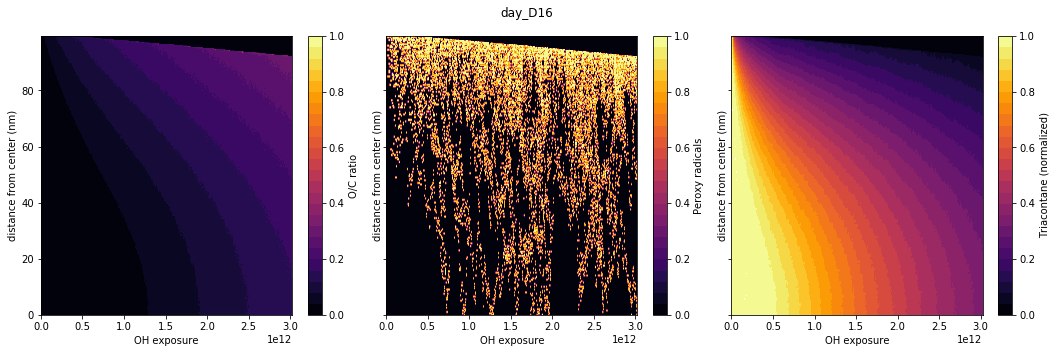

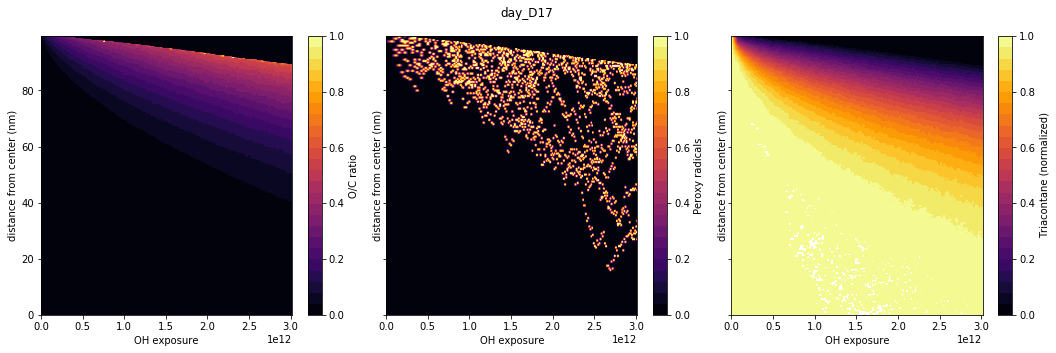

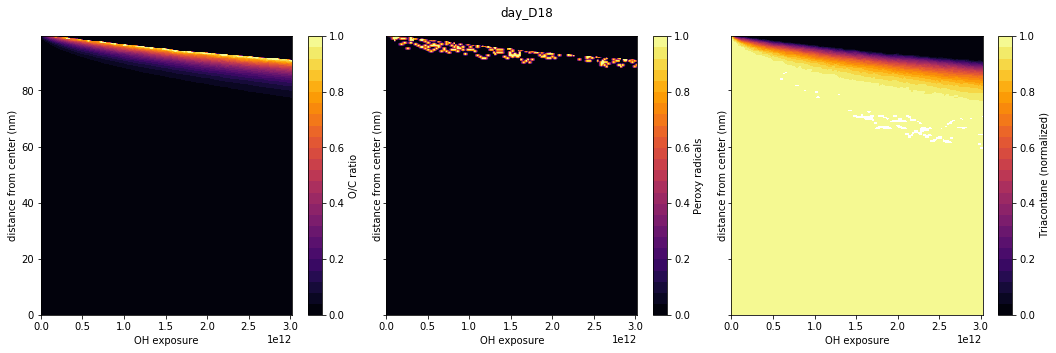

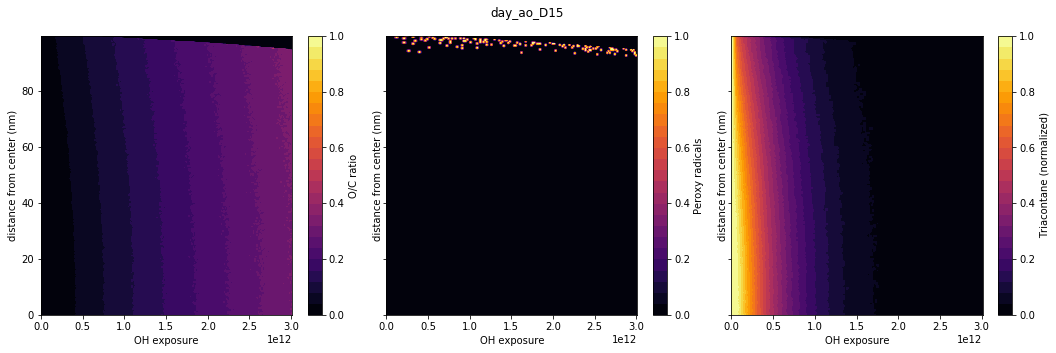

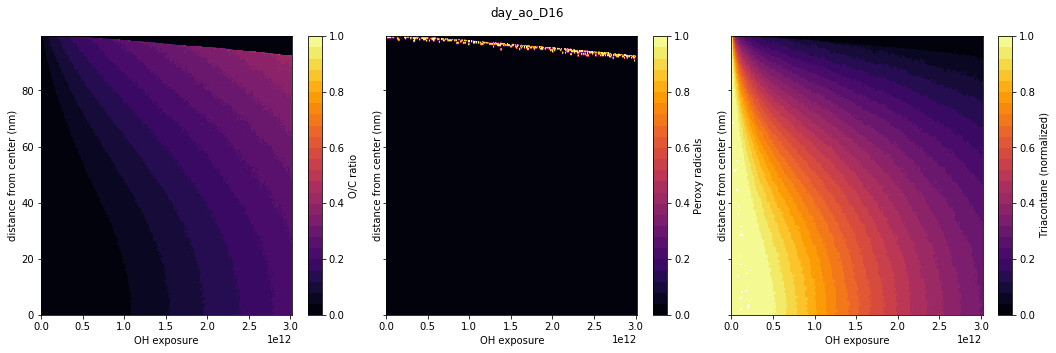

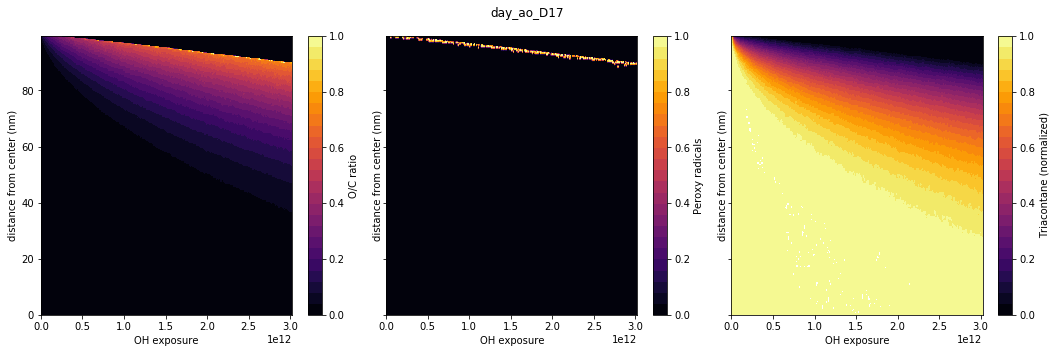

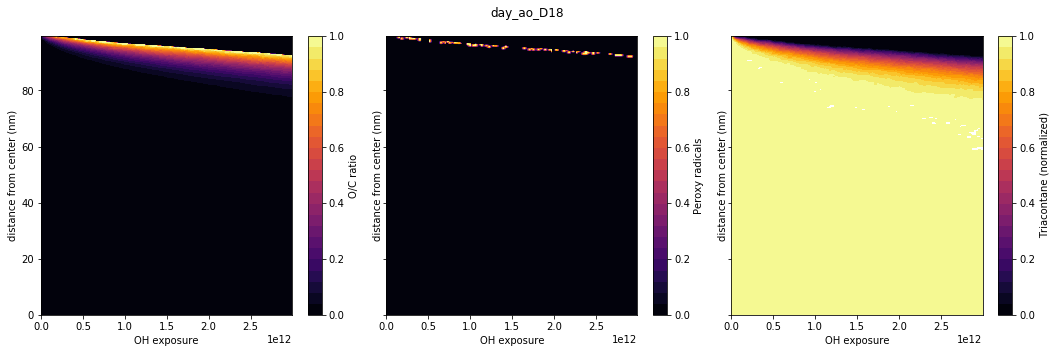

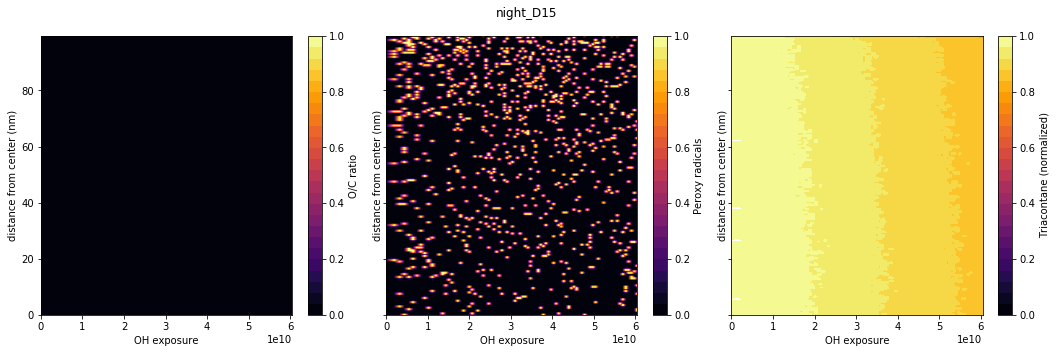

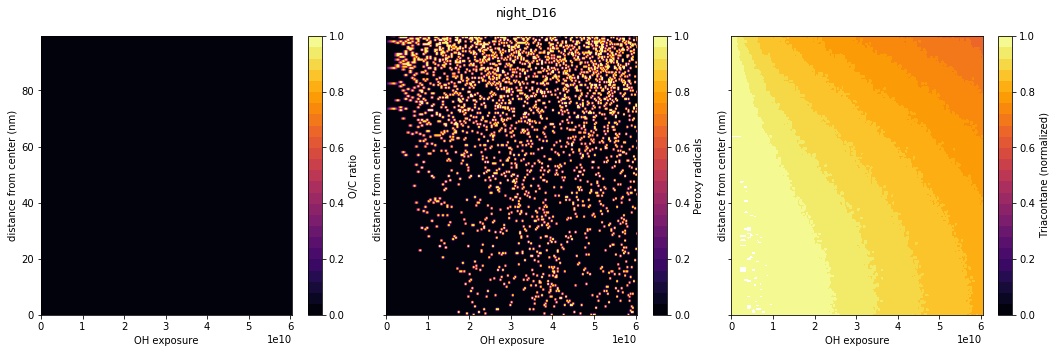

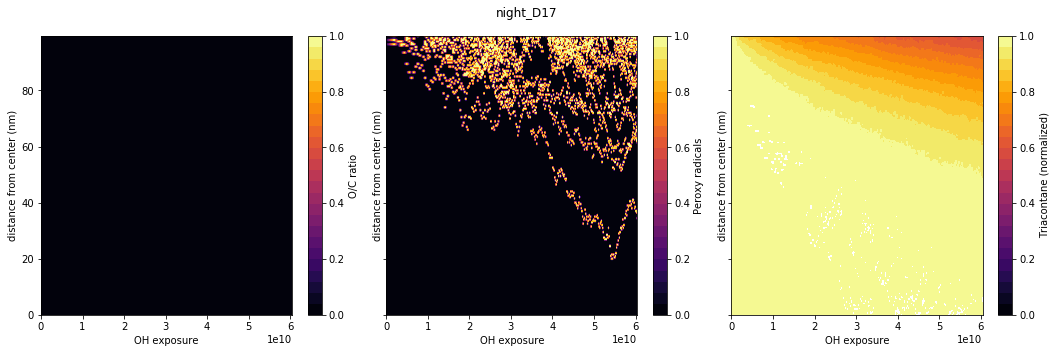

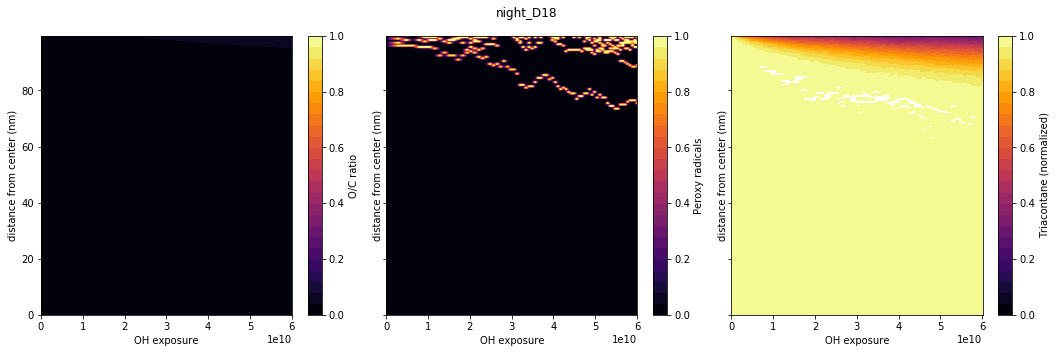

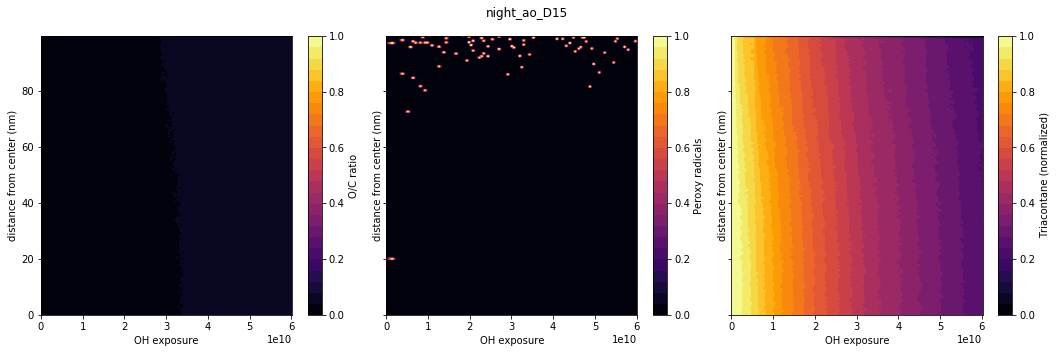

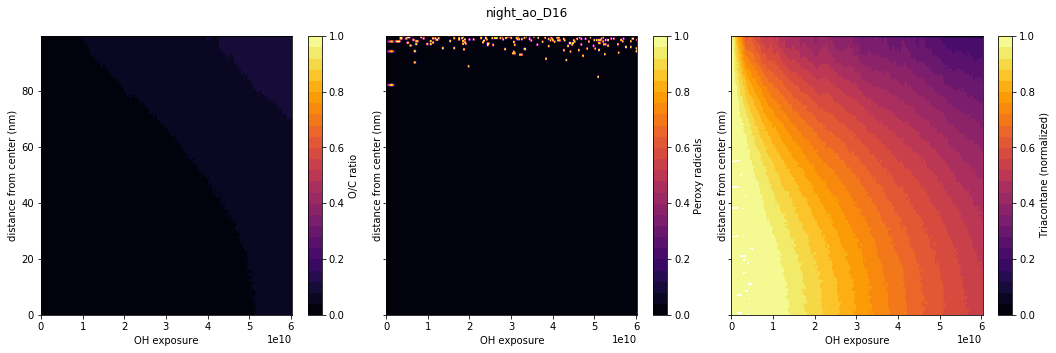

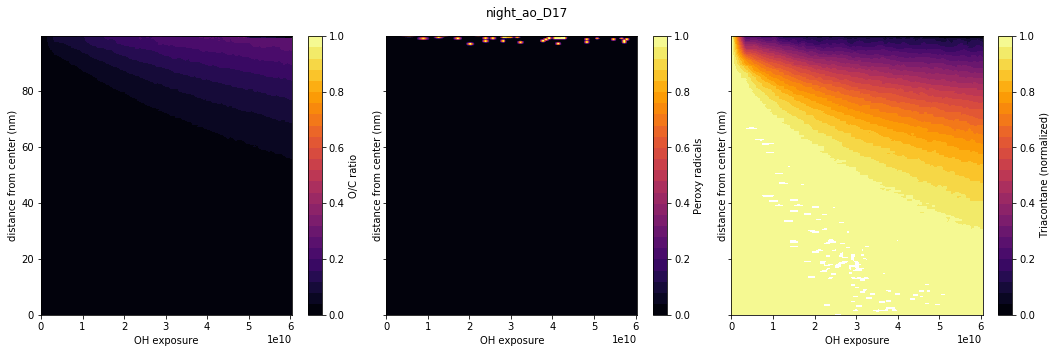

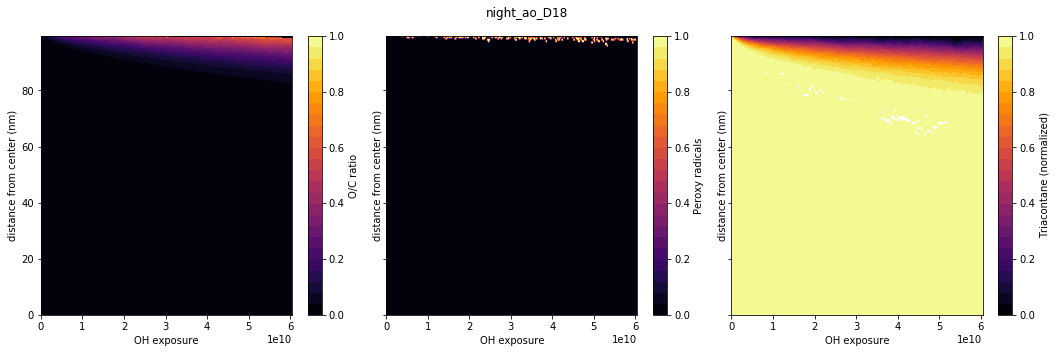

In [5]:
%matplotlib inline
for scenario in natsort.natsorted(files.keys()):
        
    # create reference to save on typing
    simulation = Scenarios[scenario]
    
    # Find OH exposure
    if "day" in scenario:
        OH = 5E6
    else:
        OH = 1E5
    
    OH_exp = OH*simulation.time
    
    # Calculate contour maps for each species
    simulation.calcContourInterpolated("Tri", reverse_axis = True)
    simulation.calcContourInterpolated("OO_sec", reverse_axis = True)
    simulation.calcContourInterpolated("O/C ratio", reverse_axis = True)
    
    # Place data into panel
    
    contour_data = {"Triacontane (normalized)": 
                    simulation.species_contour["Tri"]/simulation.species_contour["Tri"][0,0],
                   "Peroxy radicals": simulation.species_contour["OO_sec"],
                   "O/C ratio": simulation.species_contour["O/C ratio"]}
    
    ScenarioData[scenario+" contours"] = pd.Panel(contour_data, 
                                                  major_axis = simulation.position_int,
                                                 minor_axis = OH_exp)
    
    # Generate plots of contour maps
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey = True)
    
    plt.subplots_adjust(wspace=0.1, hspace=1.75)
    
    fig.suptitle(scenario)
    fig.subplots_adjust(top=0.9)
    
    i = 0
    for species, data in ScenarioData[scenario+" contours"].iteritems():
        
        # Find maximum value on contour and generate contour levels and labels
        #maximum = data.values.max()
        levels = np.linspace(0, 1, num=26)
        labels = np.linspace(0, 1, num=6)
        
        # Create contour map from data frame
        cm = axes[i].contourf(data.columns.values, data.index/1E-7, data, 
                           levels = levels, cmap='inferno')
        
        # Add axis labels
        axes[i].set_xlabel("OH exposure")
        axes[i].set_ylabel("distance from center (nm)")
        
        # Add color bar
        cb = fig.colorbar(cm, ax=axes[i], ticks=labels)
        cb.set_label(species)
        
        i += 1

## Model scenario comparison

To summarize this large data set, several average values are placed in a panel plot comparing diffusion coefficient and oxidant concentration.

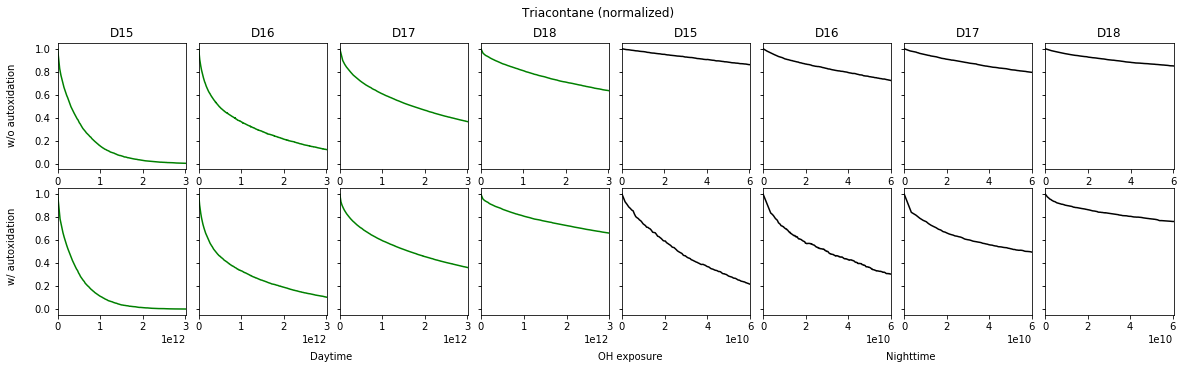

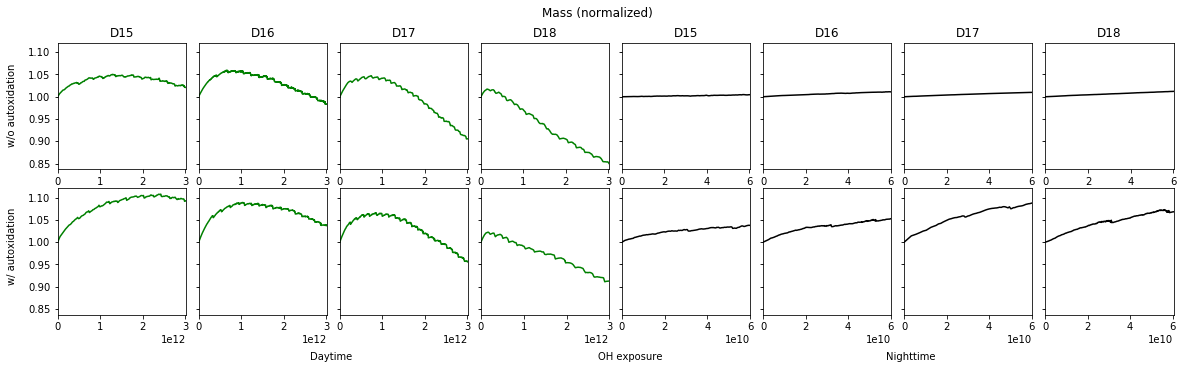

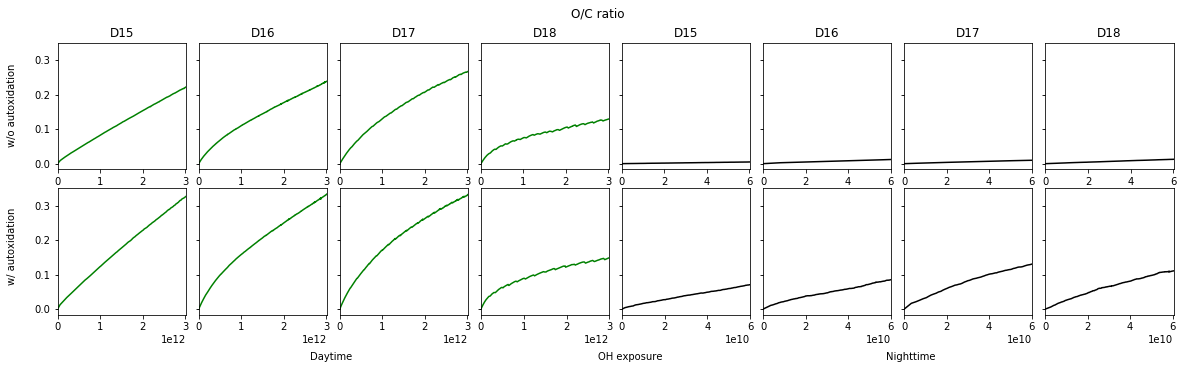

In [17]:
%matplotlib inline

properties = ["Triacontane (normalized)", "Mass (normalized)", "O/C ratio"]

for property in properties:

    fig, axes = plt.subplots(2, 8, figsize=(20, 5), sharex=False, sharey=True)

    fig.suptitle(property)

    plt.subplots_adjust(wspace=0.1, hspace=0.15)
    plt.figtext(0.5, 0, "OH exposure")
    plt.figtext(0.09, 0.8, "w/o autoxidation", rotation='vertical')
    plt.figtext(0.09, 0.4, "w/ autoxidation", rotation='vertical')
    plt.figtext(0.3, 0, "Daytime")
    plt.figtext(0.7, 0, "Nighttime")

    i = 0
    for D in diffusion:
        ScenarioData["day_"+D+" averages"].plot(ax = axes[0, i], legend = False, title = D,
                                                   x = "OH exposure", y = property, color = 'g')
        ScenarioData["day_ao_"+D+" averages"].plot(ax = axes[1, i], legend = False,
                                                   x = "OH exposure", y = property, color = 'g')
        ScenarioData["night_"+D+" averages"].plot(ax = axes[0, i+4], legend = False, title = D,
                                                   x = "OH exposure", y = property, color = 'k')
        ScenarioData["night_ao_"+D+" averages"].plot(ax = axes[1, i+4], legend = False,
                                                   x = "OH exposure", y = property, color = 'k')
        axes[1, i].xaxis.label.set_visible(False)
        axes[1, i+4].xaxis.label.set_visible(False)
        
        i += 1
    property = re.sub("/", " to ", property)
    fig.savefig(property+'_ao.png', fmt='png', dpi=300, bbox_inches='tight')

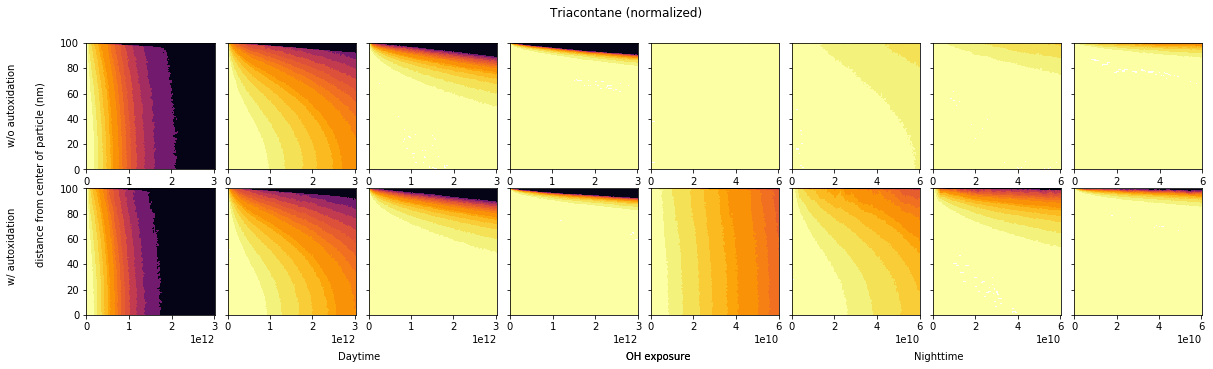

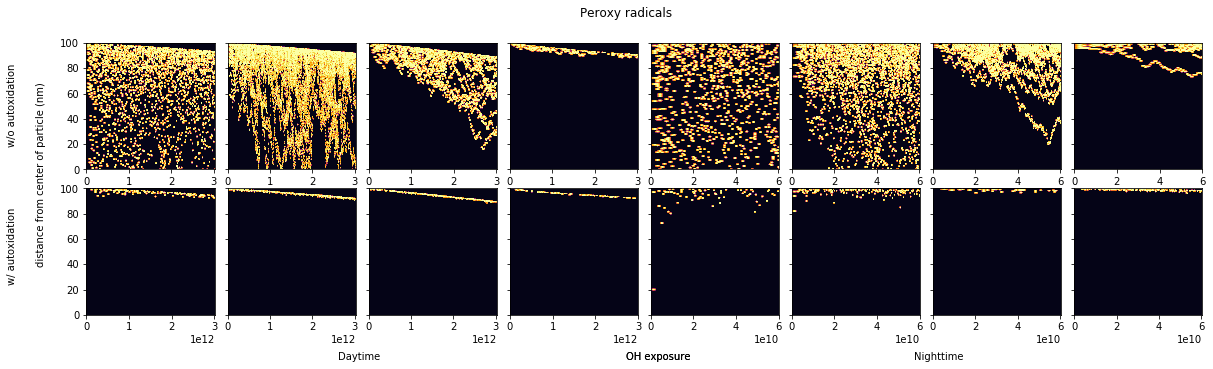

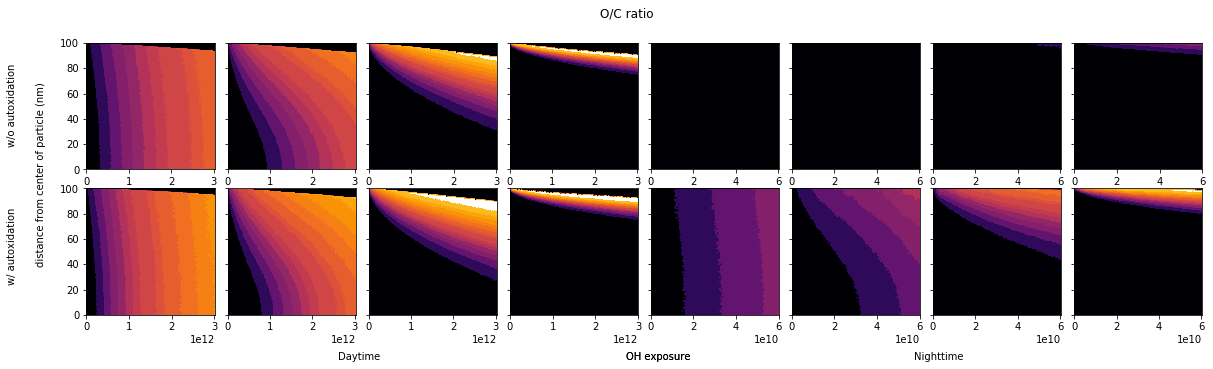

In [9]:
properties = ["Triacontane (normalized)", "Peroxy radicals", "O/C ratio"]

N_levels = 26

levels = np.array([0])
levels = np.append(levels, np.logspace(-4, 0, num=N_levels, base = np.e))
labels = np.logspace(-2, 0, num=6, base = 10)

cmap = mpl.cm.get_cmap('inferno', N_levels)
    
norm = mpl.colors.BoundaryNorm(levels, cmap.N)

for property in properties:

    fig, axes = plt.subplots(2, 8, figsize=(20, 5), sharex=False, sharey=True)

    fig.suptitle(property)

    plt.subplots_adjust(wspace=0.1, hspace=0.15)
    plt.figtext(0.5, 0, "OH exposure")
    plt.figtext(0.07, 0.8, "w/o autoxidation", rotation='vertical')
    plt.figtext(0.07, 0.4, "w/ autoxidation", rotation='vertical')
    plt.figtext(0.3, 0, "Daytime")
    plt.figtext(0.7, 0, "Nighttime")
    plt.figtext(0.5, 0, "OH exposure")
    plt.figtext(0.09, 0.75, "distance from center of particle (nm)", rotation='vertical')
    
    if property == "O/C ratio":
        levels = np.linspace(0, 0.5, num=26)
    else:
        levels = np.linspace(0, 1, num=26)
    labels = np.linspace(0, 1, num=6)
    axes[0, 0].set_ylim([0, 100])
    i = 0
    for D in diffusion:
        data = ScenarioData["day_"+D+" contours"][property]
        cm = axes[0, i].contourf(data.columns.values, data.index/1E-7, data, 
                                   levels = levels, cmap=cmap, norm=norm, spacing='uniform')
        data = ScenarioData["day_ao_"+D+" contours"][property]
        cm = axes[1, i].contourf(data.columns.values, data.index/1E-7, data, 
                                   levels = levels, cmap=cmap, norm=norm, spacing='uniform')
        data = ScenarioData["night_"+D+" contours"][property]
        cm = axes[0, i+4].contourf(data.columns.values, data.index/1E-7, data, 
                                   levels = levels, cmap=cmap, norm=norm, spacing='uniform')
        data = ScenarioData["night_ao_"+D+" contours"][property]
        cm = axes[1, i+4].contourf(data.columns.values, data.index/1E-7, data, 
                                   levels = levels, cmap=cmap, norm=norm, spacing='uniform')
        axes[1, i].xaxis.label.set_visible(False)
        axes[1, i+4].xaxis.label.set_visible(False)
        i += 1
    property = re.sub("/", " to ", property)
    fig.savefig(property+'_ao contour.png', fmt='png', dpi=300, bbox_inches='tight')